In [2]:
%cd mmdetection
import mmcv

/data/Detection_proj/mmdetection


In [3]:
import os.path as osp
import pdb
def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = mmcv.load(ann_file)
    pdb.set_trace()
    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(mmcv.track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))

        bboxes = []
        labels = []
        masks = []
        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (
                min(px), min(py), max(px), max(py))


            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{'id':0, 'name': 'balloon'}])
    mmcv.dump(coco_format_json, out_file)

In [5]:
ann_file = '../balloon/val/via_region_data.json'
out_file = '../balloon/val/train_coco.json'
image_prefix = '../balloon/val'
convert_balloon_to_coco(ann_file,out_file,image_prefix)

> <ipython-input-3-2543852e764e>(6)convert_balloon_to_coco()
      4     data_infos = mmcv.load(ann_file)
      5     pdb.set_trace()
----> 6     annotations = []
      7     images = []
      8     obj_count = 0

ipdb> c
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 38.0 task/s, elapsed: 0s, ETA:     0s


In [3]:
from mmdet.apis import set_random_seed
from mmcv import Config
from pprint import pprint
#cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py')
#faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_1x_coco.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

In [8]:
import os
import os.path as osp
CLASS = ['balloon']
# Modify dataset type and path
cfg.data_root = 'balloon/'
cfg.classes = CLASS

cfg.data.test.img_prefix = 'balloon/val/'
cfg.data.test.ann_file = 'balloon/val/val_coco.json'
cfg.data.test.classes = CLASS

cfg.data.train.ann_file = 'balloon/train/train_coco.json'
cfg.data.train.img_prefix = 'balloon/train/'
cfg.data.train.classes = CLASS

cfg.data.val.img_prefix = 'balloon/val/'
cfg.data.val.ann_file = 'balloon/val/val_coco.json'
cfg.data.val.classes = CLASS

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
#cfg.model.roi_head.mask_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_\
#coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco\
_bbox_mAP-0.378_20200504_180032-c5925ee5.pth'
# Set up working dir to save files and logs.
cfg.work_dir = './balloon_proj/faster-rcnn'

if not os.path.exists(cfg.work_dir):
    os.makedirs(cfg.work_dir)
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
#log interval by step not epoch
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = ['bbox','segm']
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')
cfg.dump(osp.join(cfg.work_dir, 'balloon_config.py'))

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

In [9]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/data/Detection_proj/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


In [10]:
model

FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [11]:
datasets[0].CLASSES

['balloon']

In [12]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

2021-07-02 18:26:01,456 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth
2021-07-02 18:26:01,457 - mmdet - INFO - Use load_from_local loader
2021-07-02 18:26:01,644 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
2021-07-02 18:26:01,

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2021-07-02 18:26:01,656 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook                      
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(LOW     

2021-07-02 18:30:30,780 - mmdet - INFO - Epoch [9][20/31]	lr: 2.500e-04, eta: 0:01:41, time: 0.940, data_time: 0.050, memory: 3607, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0090, loss_cls: 0.0401, acc: 98.6133, loss_bbox: 0.0708, loss: 0.1212
2021-07-02 18:30:40,232 - mmdet - INFO - Epoch [9][30/31]	lr: 2.500e-04, eta: 0:01:31, time: 0.946, data_time: 0.052, memory: 3607, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0062, loss_cls: 0.0342, acc: 98.7598, loss_bbox: 0.0661, loss: 0.1082
2021-07-02 18:30:52,484 - mmdet - INFO - Epoch [10][10/31]	lr: 2.500e-04, eta: 0:01:20, time: 1.122, data_time: 0.223, memory: 3607, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0059, loss_cls: 0.0317, acc: 99.0039, loss_bbox: 0.0553, loss: 0.0942
2021-07-02 18:31:01,884 - mmdet - INFO - Epoch [10][20/31]	lr: 2.500e-04, eta: 0:01:10, time: 0.940, data_time: 0.055, memory: 3607, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0090, loss_cls: 0.0491, acc: 98.1055, loss_bbox: 0.0827, loss: 0.1424
2021-07-02 18:31:11,314 - mmdet - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 4.6 task/s, elapsed: 3s, ETA:     0s

2021-07-02 18:32:18,025 - mmdet - INFO - Evaluating bbox...
2021-07-02 18:32:18,055 - mmdet - INFO - Evaluating segm...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.844
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxD

KeyError: 'segm is not in results'

In [45]:
cfg

Config (path: ./configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py): {'model': {'type': 'MaskRCNN', 'backbone': {'type': 'ResNet', 'depth': 50, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'norm_cfg': {'type': 'BN', 'requires_grad': False}, 'norm_eval': True, 'style': 'caffe', 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'open-mmlab://detectron2/resnet50_caffe'}}, 'neck': {'type': 'FPN', 'in_channels': [256, 512, 1024, 2048], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.5, 1.0, 2.0], 'strides': [4, 8, 16, 32, 64]}, 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder', 'target_means': [0.0, 0.0, 0.0, 0.0], 'target_stds': [1.0, 1.0, 1.0, 1.0]}, 'loss_cls': {'type': 'CrossEntropyLoss', 'use_sigmoid': True, 'loss_weight': 1.0}, 'loss_bbox': {'type': 'L1Loss', 'loss_weight': 1.0}}, 'roi_head': {'type': 'StandardRoIHead',

/data/Detection_proj/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


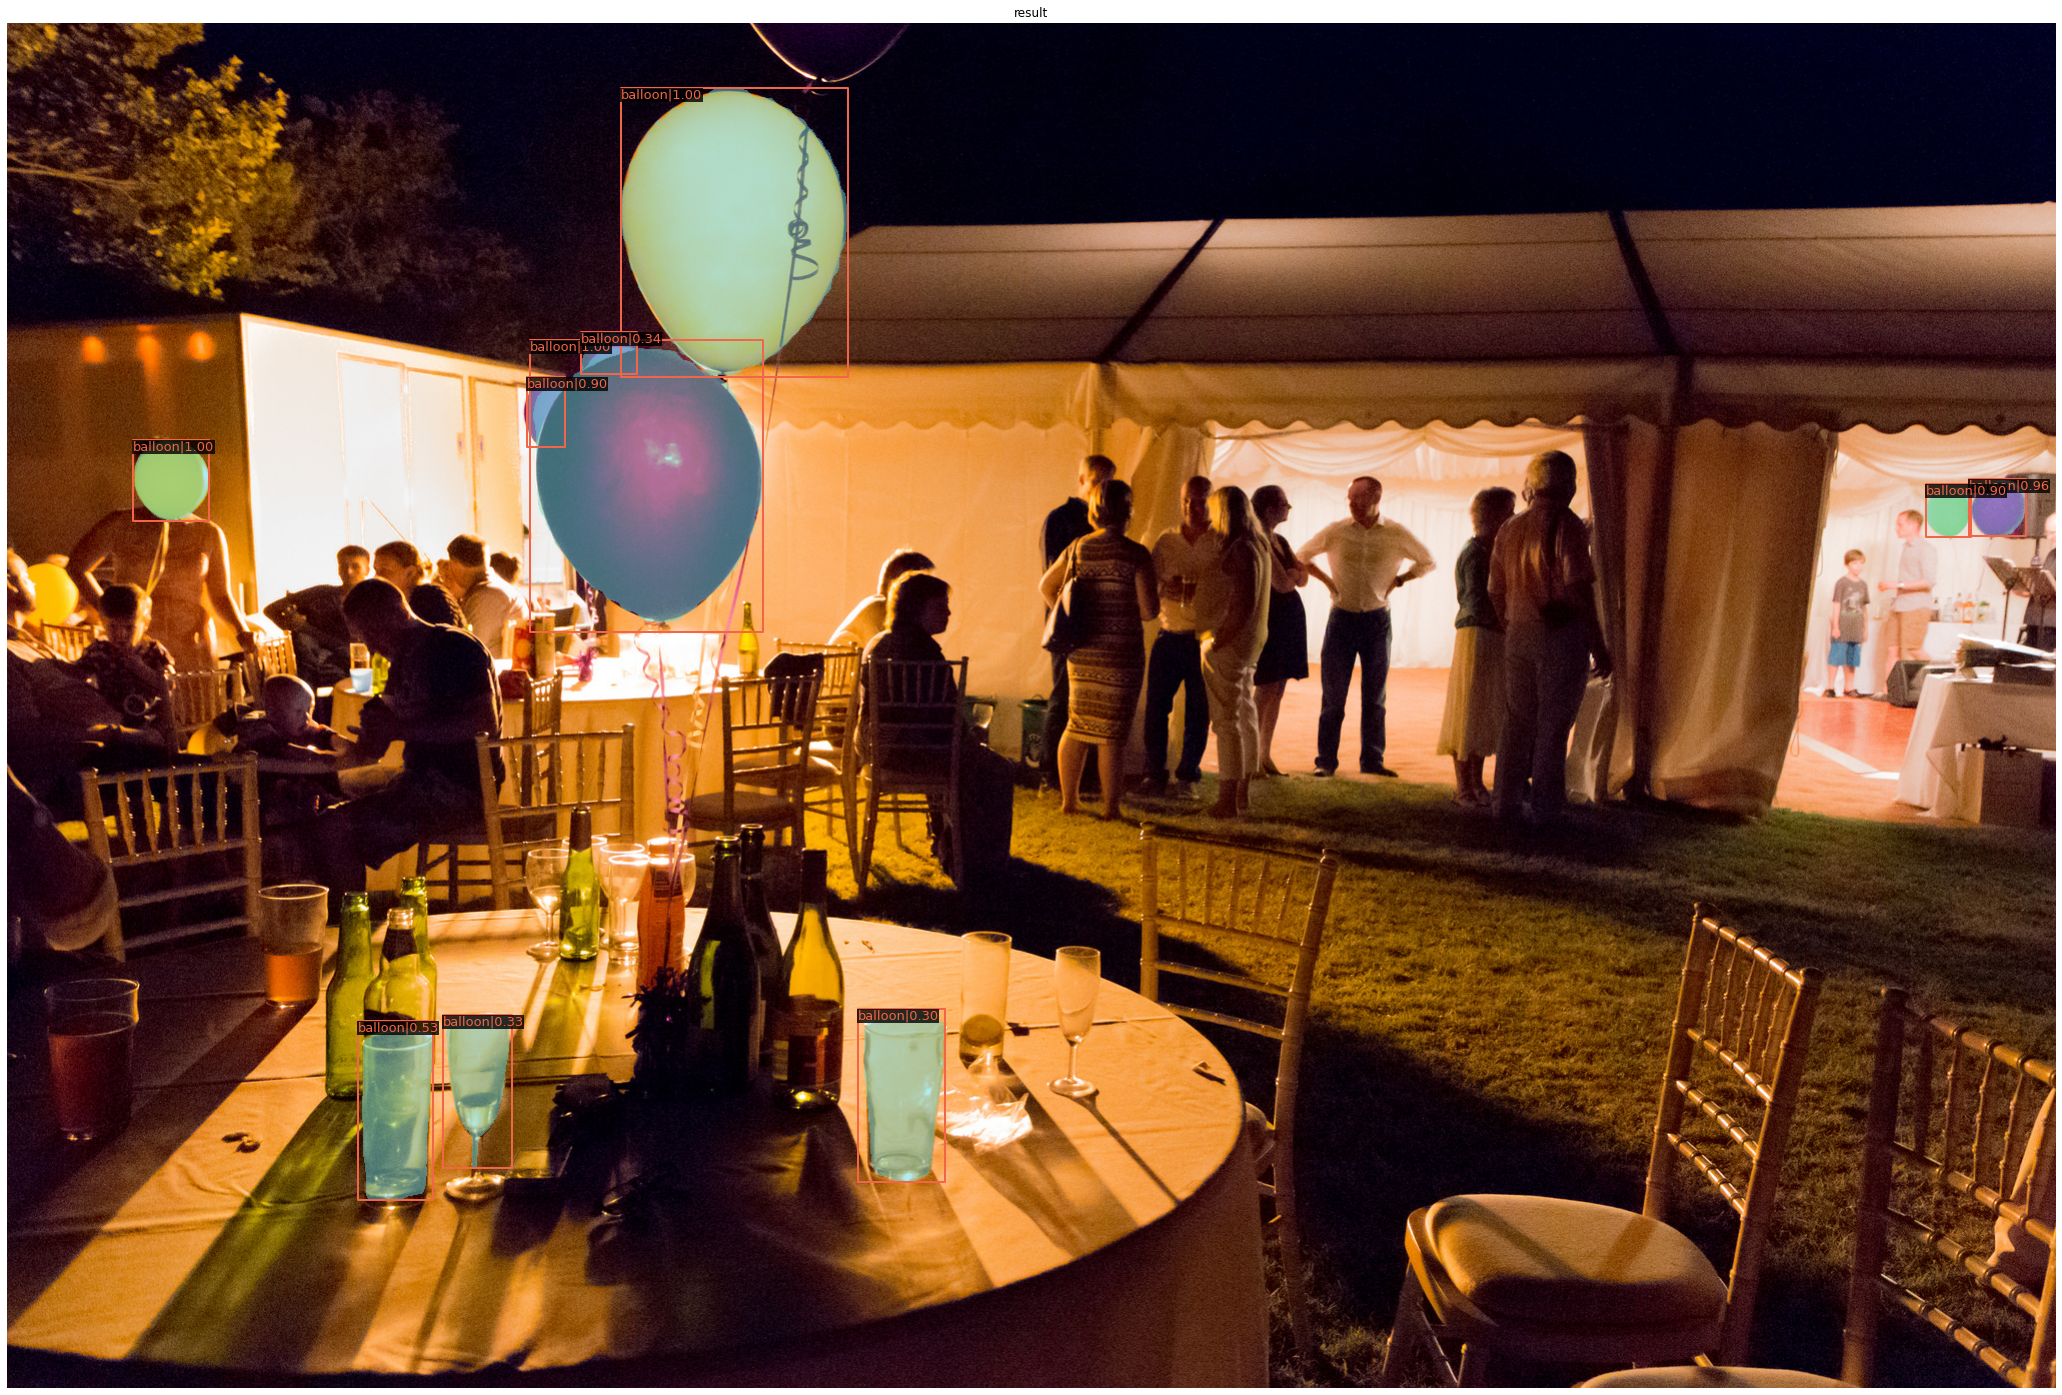

In [47]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = mmcv.imread('balloon/val/14898532020_ba6199dd22_k.jpg')
cfg.evaluation.metric=['bbox', 'segm']
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [ ]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=2,
    workers_per_gpu=2,
    dist=False,
    shuffle=False)
    
outputs = single_gpu_test(model, data_loader, args.show, args.show_dir, args.show_score_thr)

In [49]:
!python tools/test.py  balloon_proj/balloon_config.py balloon_proj/epoch_12.pth --work-dir balloon_proj --eval ['segm','bbox']

Traceback (most recent call last):
  File "tools/test.py", line 15, in <module>
    from mmdet.apis import multi_gpu_test, single_gpu_test
  File "/data/Detection_proj/mmdetection/mmdet/apis/__init__.py", line 1, in <module>
    from .inference import (async_inference_detector, inference_detector,
  File "/data/Detection_proj/mmdetection/mmdet/apis/inference.py", line 11, in <module>
    from mmdet.datasets import replace_ImageToTensor
  File "/data/Detection_proj/mmdetection/mmdet/datasets/__init__.py", line 2, in <module>
    from .cityscapes import CityscapesDataset
  File "/data/Detection_proj/mmdetection/mmdet/datasets/cityscapes.py", line 16, in <module>
    from .coco import CocoDataset
  File "/data/Detection_proj/mmdetection/mmdet/datasets/coco.py", line 14, in <module>
    from .api_wrappers import COCO, COCOeval
  File "/data/Detection_proj/mmdetection/mmdet/datasets/api_wrappers/__init__.py", line 1, in <module>
    from .coco_api import COCO, COCOeval
  File "/data/Detecti